**Group 2318**

- Guillermo Benito Calviño - 2072106 
- Claudia Lorenzetti - 2097902
- Leon Mengoni - 2091185
- Filippo Pra Floriani - 2089902

# BAYESIAN INFERENCE ON SOLAR DYNAMO

Import all the needed packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner
from scipy.special import erf
from scipy.linalg import det
from scipy.optimize import minimize
import tqdm
from scipy.fft import fft, ifft
from multiprocessing import Pool
from IPython.display import display, Math
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main

# Solar Dynamo Model

The sun's magnetic field is generated by an inner magnetic dynamo. 
It is well known that it changes in a cyclic manner with a period of almost 11 years: the existence of such a stable period indicates that the magnetic field continues to be generated within the Sun. 
The amplitude of the oscillator is subject to a long-term modulation, including periods of very low activity, known as Grand Minima. 
It is believed that Grand Minima are induced by the tiny planetary tidal forcing.

The model equation for the Solar Dynamo is:

$$
\left(\tau\frac{d}{dt} + 1\right)^2 B(t) = - \mathcal{N}(1 + \epsilon\cos(\omega_d t))f(B(t - q))B(t - q) + \sigma B_{max} \sqrt{\tau} \eta(t)
$$


- $B(t)$ is the magnetic field, our observable
- $\mathcal{N} $ is the strength of the dynamo
- $q$ is the delay
- $[\sigma] = [1]$ (dimensionless) is the noise amplitude 
- $[\tau] = [s]$ is the diffusion-time constant
- $\eta (t)$ is the so-called gaussian white noise
- $T$ is the observation time
- $\epsilon\cos(\omega_d t)$ is the weak external modulation induced by a tiny planetary tidal forcing


- Non-linear function $f(B(t))$:

$$
f(B(t)) = \frac{1}{2} (1 + \text{erf}(B^2 - B_{max}^2))
$$

used for constraining the B field under a certain value.

# Bayesian Inference

Our scope is to find the best parameters that fit the model. 
To achieve this, we want to construct the posterior for our parameters $\boldsymbol{\theta} = (q, \mathcal{N}, \sigma, B_{max}, \tau)$: 

$$
    p(\boldsymbol{\theta}|B) \propto f(B|\boldsymbol{\theta})p(\boldsymbol{\theta})
$$

given the likelihood $f(B|\boldsymbol{\theta})$ and our parameter prior $p(\boldsymbol{\theta})$, i.e. our previous knowledge. 
In this case we just require our parameters to be positive.


In our case, instead of working with our time-dependent signal, we convert our model equation to Fourier space, and we sample the posterior in Fourier space by using a Markov Chain Monte Carlo algorithm:

$$
    p(\boldsymbol{\theta}|\widehat{B}) \propto f(\widehat{B}|\boldsymbol{\theta})p(\boldsymbol{\theta})
$$

However, instead of sampling from the distribution of $\widehat{B}$, we want to sample from the distribution of $\widehat{\eta}$, because $\eta$ is a gaussian white noise and its Fourier transform is also distributed as a gaussian.
We therefore express $\widehat{\eta}$ as a function of $\widehat{B}$.

After having sampled our posterior, we obtain the best estimates through the use of a minimization algorithm.

## Model equation to Fourier space

First of all we want to convert our model to the frequency domain by applying a Fourier transform. 
In this way it is possible to focus just on the frequency modes which are more interesting to be analyzed, by filtering out the negligible ones.

We define the Fourier transform of our signal $B(t)$ as the $n$-th coefficient of the complex Fourier series:

$$
    \mathcal{F}[B(t)]_n = \widehat{B}_n = \frac{1}{T} \int^{T}_0 dt e^{- 2 \pi i n \frac{t}{T}} B(t)
$$

In order to prevent spectral-leakage, a window function will be used. In this case we will use the Hann window function:

$$
    w (t) = \cos^2\left(\pi\left(\frac{t}{T} - \frac{1}{2}\right)\right)
$$

The application of $w(t)$ to our signal helps modulate the trend of the ODE, by suppressing the function near $t = 0$ and $t = T$, whose period is forced to be exactly $T$.


The original signal is defined as $B(t)$ and the white noise as $\eta(t)$, while the "windowed" signal and the "windowed" noise are respectively:

$$
B^w(t) = w(t)B(t) \hspace{1cm} \eta^w(t) = w(t) \eta(t)
$$

and the non-linear function has been rewritten as: 

$$
    \widetilde{f}(B(t))=f(B(t))B(t)
$$

The Fourier transform of our windowed signal is, therefore:

$$
    \mathcal{F}[B^w(t)]_n = \widehat{B}^w_n = \frac{1}{T} \int^{T}_0 dt e^{- 2 \pi i n \frac{t}{T}} B^w(t)
$$

We can now convert the windowed model to Fourier space.

### Full-equation transformed

Finally, the full equation with window function transformed to Fourier space is:

$$
    \left(\frac{2 \pi i n\tau}{T} + 1 \right)^2 \widehat{B}^{w}_n = -\mathcal{N} e^{-2 \pi i n \frac{q}{T}} \cos^2\left(\pi\frac{q}{T}\right) \mathcal{F}\big\{[1 + \epsilon\cos(\omega_d (t+q))]\widetilde{f}^w\big\}_n + \sigma B_{max} \sqrt{\tau} \widehat{\eta}^w_n
$$

To proceed with the inference, we have to isolate $\widehat{\eta}^w_n$ by writing it as a function of $\widehat{B}^w_n$:

$$
    \widehat{\eta}^w_n = \frac{\left(\frac{2 \pi i n\tau}{T} + 1 \right)^2 \widehat{B}^{w}_n + \mathcal{N} e^{-2 \pi i n \frac{q}{T}} \cos^2\left(\pi\frac{q}{T}\right) \mathcal{F}\big\{[1 + \epsilon\cos(\omega_d (t+q))]\widetilde{f}^w\big\}_n}{\sigma B_{max}\sqrt{\tau}}
$$

With or without windowing, the formal expression of the equation is the same.


Without the external modulation ($\epsilon=0$), $\widehat{\eta}^w_n$ is written as: 

$$
    \widehat{\eta}^w_n = \frac{\left(\frac{2 \pi i n\tau}{T} + 1 \right)^2 \widehat{B}^{w}_n + \mathcal{N} e^{-2 \pi i n \frac{q}{T}} \cos^2\left(\pi\frac{q}{T}\right) \mathcal{F}[\widetilde{f}^w]_n}{\sigma B_{max}\sqrt{\tau}}
$$

## Likelihood function

We now want to define the likelihood function for the transformed signal in $\widehat{\eta^w}$.

The transformed noise $\widehat{\eta}_n$ is distributed following a normal distribution:

$$
    f(\widehat{\eta}_n|\boldsymbol{\theta}) \propto \exp\left(-\frac{1}{2} |\widehat{\eta}_n|^2\right)
$$

Therefore, given $\widehat{\boldsymbol{\eta}}=(...,\widehat{\eta}_{-1},\widehat{\eta}_{0},\widehat{\eta}_{1},...)$, the distribution of $\boldsymbol{\widehat{\eta}}$ is given by the product

$$
    f(\widehat{\boldsymbol{\eta}}|\boldsymbol{\theta}) = \prod_n f(\widehat{\eta}_n) \propto \exp\left(-\frac{1}{2}\sum_n|\widehat{\eta}_n|^2\right) = \exp\left(-\frac{1}{2}\boldsymbol{\widehat{\eta}}^T\boldsymbol{\widehat{\eta}}\right)
$$


The likelihood function for $\widehat{\boldsymbol{B}}$ in Fourier space is obtained from the change of variables $\widehat{\boldsymbol{\eta}} \longrightarrow \widehat{\boldsymbol{B}}$:

$$
    \mathcal{L} = f(\widehat{\boldsymbol{B}}|\boldsymbol{\theta}) = f(\widehat{\boldsymbol{\eta}}|\boldsymbol{\theta})\big|_{\widehat{\boldsymbol{\eta}}=\widehat{\boldsymbol{\eta}}(\widehat{\boldsymbol{B}})}\cdot\left\lvert\frac{d\widehat{\boldsymbol{\eta}}}{d\widehat{\boldsymbol{B}}}\right\rvert
$$



However, when we deal with a windowed signal, such as $B^w(t)$, correlations arise between different modes of the Fourier transform. Therefore, the probability distribution $f(\boldsymbol{\widehat{\eta}^w}|\boldsymbol{\theta})$ is not a simple product of independent gaussian distributions anymore, and the covariance matrix $\Sigma_{n,m} = \langle\widehat{\eta}^w_n, \widehat{\eta}^w_m\rangle$ must be included:

$$
        f(\boldsymbol{\widehat{\eta}^w}|\boldsymbol{\theta}) \propto \exp\left(-\frac{1}{2}\left(\boldsymbol{\widehat{\eta}^w}\right)^T\Sigma^{-1}\boldsymbol{\widehat{\eta}^w}\right)
$$

However, we can ignore the covariance matrix by sampling every 3 nodes: this is how we will lighten the computations in our code. 

Before computing the Jacobian, we should taking into account that, since we are working with the discrete signal $\boldsymbol{B}=(B(t_0), B(t_1), ... , B(t_{N-1}))$, we will not have the integral as we have written ahead, but we will be using the Discrete Fourier Transform (DFT):

$$
    \mathcal{F}[\boldsymbol{B}]_n = \widehat{B}_n =\sum_{i=0}^{N-1} e^{-2\pi i n\frac{t_i}{T}}B(t_i)
$$

and its inverse:

$$
    \mathcal{F}^{-1}[\widehat{\boldsymbol{B}}](t_i) = B(t_i) = \frac{1}{N}\sum_{n=0}^{N-1}e^{2\pi i n \frac{t_i}{T}} \widehat{B}_n
$$


The Jacobian element $(m, n)$, setting $\epsilon = 0$, is given by:

$$
J^w_{n,m} = \frac{1}{\sigma B_{max}\sqrt{\tau}}\bigg[\left(\frac{2 \pi i n\tau}{T} + 1 \right)^2 \delta_{nm} + \mathcal{N} e^{-2 \pi i n \frac{q}{T}} \mathcal{F}\big[\widetilde{f}^w\big]_n\bigg] 
$$
Therefore, we can write our sampling posterior for $\epsilon = 0$, as:
 
$$
        f(\widehat{B}^w|\boldsymbol{\theta})  \propto |\det J^{w}| \exp\bigg(-\frac{1}{2\sigma^2 B_{max}^2\tau}\sum_n \bigg\lvert\left(\frac{2 \pi i n\tau}{T} + 1 \right)^2 \widehat{B}^{w}_n \, + 
          \mathcal{N} e^{-2 \pi i n \frac{q}{T}} \cos^2\left(\pi\frac{q}{T}\right) \mathcal{F}\big[\widetilde{f}^w\big]_n\bigg\rvert^2\bigg) 
$$

### SET THE CONFIGURATION FOR ALL THE SAMPLINGS

In [2]:
# Set configuration

WINDOW = True   #use window in the fourier transform
one_parameter=True    #use one_parm=sigma*Bmax*sqrt(tau) instead of sigma
cos = True           # use cos(q/T) correction in log_likelihood
covariance = False  # use covariance in log_likelihood
extended_box = False  # use the box function with both Bmax and Bmin
Bmin=1                #fixed (not a parameter)
jeffrey_prior = True     # use Jeffrey's prior for sigma or one_parameter

n_max = 170         
each_ = 3
if covariance:
    each=1
else:
    each=each_

maximum=True   ## set maximum value for Bmax and q in the prior

with_pool = False      #paralelize the sampling
steps_emcee = 5000
rep_emcee = 1             # how many repetitions of EMCEE
walkers=50  
burn=25 #burn in
thining=1

filepath = "D:\\Users\\prafl\\Documents\\PoD\\LaboratoryOfComputationalPhysics_Y5\\project\\"  ##path where SDDE.jl is and data will be saved

Load the real data

In [3]:
B_real= np.loadtxt('bfield_from_sunspots.dat', delimiter=',')
t=np.arange(0,len(B_real))

### BAYESIAN INFERENCE FUNCTIONS

Return the log posterior function for the given configuration

In [4]:
def bayesian_inference(t, B, p):
    
    n = np.arange(0, len(t))
    n_list = n[0:n_max:each]
    T=len(t)
    # Define window
    def w(t):
        if WINDOW:
            return np.cos(np.pi * (t / T - 0.5))**2
        else:
            return 1


    # Define box * B
    def f_erf(B,Bmax): 
        if extended_box:
            res = (B/4) * (1+erf(B**2-Bmin**2)) * (1-erf(B**2-Bmax**2))
        else:
            res = 0.5 * (1 - erf(B**2 - Bmax**2)) * B
        return res


    # Find B windowed and Fourier transformed
    Bw = B * w(t) 
    Bw_hat_tot = fft(Bw)

    # Find the derivative of the Fourier transorm of the f tilde
    nm_t = np.multiply.outer(np.subtract.outer(n_list,n_list),t)
    expo = np.exp(-2*np.pi*1j*nm_t/T)


    # Select each 3 modes
    Bw_hat = Bw_hat_tot[0:n_max:each]


    # Variance 
    var_w =np.abs(fft(w(t)**2))


    # Covariance matrix
    cov=(np.diag([var_w[0]]*len(n_list))+np.diag([var_w[1]]*(len(n_list)-1),1)+np.diag([var_w[2]]*(len(n_list)-2),2)+np.diag([var_w[1]]*(len(n_list)-1),-1)+np.diag([var_w[2]]*(len(n_list)-2),-2))
    inv_cov=np.linalg.inv(cov)
    
    if maximum:    
        Bmax_max=max(B)
        q_max=3*q
    
    else:
        Bmax_max=np.inf
        q_max=np.inf


    if one_parameter:
        # Define log_prior
        def log_prior(theta):
            q, N, one_param, Bmax, tau = theta
            if (q      > 0     and
                q      < q_max and
                N      > 0    and
                one_param  >0 and
                Bmax   > 0 and 
                Bmax < Bmax_max and
                tau    > 0):
                if jeffrey_prior:
                    return -0.5*np.log(one_param)   
                else:
                    return 1
            else:
                return -np.inf


        # Define log_likelihood
        def log_likelihood(theta):
            q, N, one_param, Bmax, tau = theta

            koef = (2 * np.pi * 1j * n_list * tau /T + 1)

            f = f_erf(B,Bmax)
            f_hat = fft(f*w(t))
            f_hat = f_hat[0:n_max:each]

            if extended_box:
                func = 0.25*(1-erf(B**2 - Bmax**2))*(1+erf(B**2 - Bmin**2)) - (B**2/np.sqrt(np.pi))*(1+erf(B**2 - Bmin**2))*np.exp(-(B**2 - Bmax**2)**2) + (B**2/np.sqrt(np.pi))*(1-erf(B**2 - Bmax**2))*np.exp(-(B**2 - Bmin**2)**2)    
            else:
                func = -(2 * B**2 / np.sqrt(np.pi)) * np.exp(-(B**2 - Bmax**2)**2) - 0.5 * erf((B**2 - Bmax**2)) + 0.5  #derivative of ftilde
            dFf_dBhat = expo @ func / len(t)
            #dFf_dBhat = np.subtract.outer(fft(func)[0:n_max:each], fft(func)[0:n_max:each]) / len(t)


            if covariance:
                if cos:
                    eta_hat = (koef**2 * Bw_hat + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * np.cos(np.pi * q / T)**2 * f_hat)/one_param
                    jacobian = (np.diag(koef**2) + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * np.cos(np.pi * q / T)**2 * dFf_dBhat)/one_param
                    det_j = np.abs(det(jacobian))
                else:
                    eta_hat = (koef**2 * Bw_hat + N * np.exp(-2 * np.pi * 1j * n_list * q /T) * f_hat)/one_param
                    jacobian = (np.diag(koef**2) + N * np.exp(-2 * np.pi * 1j * n_list * q /T) * dFf_dBhat)/one_param
                    det_j = np.abs(det(jacobian))

                log_likelihood = np.log(det_j)  -   0.5 * np.abs(np.conjugate(eta_hat)@inv_cov@eta_hat)

            else:
                if cos:
                    eta_hat = (koef**2 * Bw_hat + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * np.cos(np.pi * q / T)**2 * f_hat)/one_param
                    jacobian = (np.diag(koef**2) + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * np.cos(np.pi * q / T)**2 * dFf_dBhat)/one_param
                    det_j = np.abs(det(jacobian))
                else:
                    eta_hat = (koef**2 * Bw_hat + N * np.exp(-2 * np.pi * 1j * n_list * q /T ) * f_hat)/one_param
                    jacobian = (np.diag(koef**2) + N * np.exp(-2 * np.pi * 1j * n_list * q /T) * dFf_dBhat)/one_param
                    det_j = np.abs(det(jacobian))

                log_likelihood =  - 0.5 * np.sum(np.abs(eta_hat)**2) / var_w[0] +np.log(det_j)
                #print(log_likelihood)

            return log_likelihood


        # Define log_posterior   
        def log_probability(theta):
            q, N, sigma, Bmax, tau = theta
            lp = log_prior(theta)
            if not np.isfinite(lp):
                return -np.inf
            else:
                return lp + log_likelihood(theta)



    else:
        # Define log_prior
        # Define log_prior
        def log_prior(theta):
            q, N, one_param, Bmax, tau = theta
            if (q      > 0     and
                q      < q_max and
                N      > 0    and
                sigma  >0 and
                Bmax   > 0 and 
                Bmax < Bmax_max and
                tau    > 0):
                if jeffrey_prior:
                    return -0.5*np.log(one_param)   
                else:
                    return 1
            else:
                return -np.inf

        # Define log_likelihood
        def log_likelihood(theta):
            q, N, sigma, Bmax, tau = theta
            coef = sigma * Bmax * np.sqrt(tau)
            koef = (2 * np.pi * 1j * n_list * tau/T  + 1)

            f = f_erf(B,Bmax)
            f_hat = fft(f*w(t))
            f_hat = f_hat[0:n_max:each]

            if extended_box:
                func = 0.25*(1-erf(B**2 - Bmax**2))*(1+erf(B**2 - Bmin**2)) - (B**2/np.sqrt(np.pi))*(1+erf(B**2 - Bmin**2))*np.exp(-(B**2 - Bmax**2)**2) + (B**2/np.sqrt(np.pi))*(1-erf(B**2 - Bmax**2))*np.exp(-(B**2 - Bmin**2)**2)    
            else:
                func = -(2 * B**2 / np.sqrt(np.pi)) * np.exp(-(B**2 - Bmax**2)**2) - 0.5 * erf((B**2 - Bmax**2)) + 0.5  #derivative of ftilde
            dFf_dBhat = expo @ func / len(t)
            #dFf_dBhat = np.subtract.outer(fft(func)[0:n_max:each], fft(func)[0:n_max:each]) / len(t)



            if covariance:
                if cos:
                    eta_hat = (koef**2 * Bw_hat + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * np.cos(np.pi * q / T)**2 * f_hat)/coef
                    jacobian = (np.diag(koef**2) + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * np.cos(np.pi * q / T)**2 * dFf_dBhat)/coef
                    det_j = np.abs(det(jacobian))
                else:
                    eta_hat = (koef**2 * Bw_hat + N * np.exp(-2 * np.pi * 1j * n_list * q /T ) * f_hat)/coef
                    jacobian = (np.diag(koef**2) + N * np.exp(-2 * np.pi * 1j * n_list * q/T) * dFf_dBhat)/coef
                    det_j = np.abs(det(jacobian))

                log_likelihood = np.log(det_j)  -   0.5 * np.abs(np.conjugate(eta_hat)@inv_cov@eta_hat)

            else:
                if cos:
                    eta_hat = (koef**2 * Bw_hat + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * np.cos(np.pi * q / T)**2 * f_hat)
                    jacobian = (np.diag(koef**2) + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * np.cos(np.pi * q / T)**2 * dFf_dBhat)
                    det_j = np.abs(det(jacobian))
                else:
                    eta_hat = (koef**2 * Bw_hat + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * f_hat)
                    jacobian = (np.diag(koef**2) + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * dFf_dBhat)
                    det_j = np.abs(det(jacobian))

                log_likelihood = np.log(det_j) + np.log(1/coef) * len(n_list) - (1/coef**2) * 1/var_w[0] * 0.5 * np.sum(np.abs(eta_hat)**2)

            return log_likelihood


        # Define log_posterior   
        def log_probability(theta):
            q, N, sigma, Bmax, tau = theta
            lp = log_prior(theta)
            if not np.isfinite(lp):
                return -np.inf
            else:
                return lp + log_likelihood(theta)
            
    return log_probability, Bw_hat,Bw,n_list

Return the minima of the log posterior using scipy minimize

In [5]:
def find_minima(log_prob,p):
    nll = lambda *args: -log_prob(*args)
    initial = np.array(p) + 0.01*np.array(p) * np.random.randn(len(p))
    soln = minimize(nll, initial, args=())
    minima = soln.x
    print('Minima',minima,'\n','Starting parameters',p)
    return(minima)

Plot:
- Data
- Windowed data
- Fourier transform of the data (only the selected nodes)

In [6]:
def plots(t,B,Bw,n_list):
    fig,(ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,8))
    fig.tight_layout(pad=3)
    ax1.plot(t,B,label='B')
    ax1.plot(t,Bw,label='B windowed')
    ax1.set_xlabel('Time [month]')
    ax1.set_ylabel('B')
    ax1.legend()
   
   
    
    ax2.plot(n_list,np.abs(Bw_hat),label='Fourier transform of B field')
    ax2.set_ylabel(r'$\mathcal{F}(B)$')
    ax2.set_xlabel('Mode n')
    ax2.legend()

Create data using the model for a given set of parameters (using julia for solving de SDDE).

In [7]:
def generate_data(p):
    q, N, sigma, Bmax, tau = p

    julia_code = f"""
    include("SDDE.jl")

    tau = {tau}
    N = {N}
    sigma = {sigma}
    Bmax = {Bmax}
    q = {q}
    p = (q, N, sigma, Bmax, tau)

    simulated_data(p)
    """

    Main.eval(julia_code)

    filename = f"SunspotSimulatedData_tau{tau}_N{N}_sigma{sigma}_Bmax{Bmax}_q{q}.csv"

    data_simulated = np.loadtxt(filepath + filename, delimiter=',')
    return(data_simulated)

Plot the generated and real data.

In [8]:
def plot_real_and_simulated_data(data_simulated,p, compare_real):
    q, N, sigma, Bmax, tau = p

    plt.figure(figsize=(10,6))
    plt.plot(data_simulated, label="Predicted data")
    if compare_real:
        plt.plot(B_real, label="Real data")
        
    plt.title(fr"Plot: $\tau$={round(tau,1)}, N={round(N,2)}, $\sigma$={round(sigma,3)}, Bmax={round(Bmax,1)}, q={round(q,1)}")
    plt.xlabel('Time [month]')
    plt.ylabel('B')
    plt.legend()
    #plt.show()


Create the Markov chain using emcee package.

In [9]:
def sampler_emcee(log_prob,p):
    if with_pool:    
    #np.random.seed(42)
        p_init = p
        for i in range(rep_emcee):
            pos = p_init + 1e-2*np.array(p)* np.random.randn(walkers, len(p))
            initial = pos
            nwalkers, ndim = initial.shape

            with Pool() as pool:
                sampler = emcee.EnsembleSampler(
                    nwalkers, ndim, log_prob, args=(),pool=pool
                )
                sampler.run_mcmc(initial, steps_emcee, progress=True)
                samples = sampler.get_chain()
                p_init = [np.mean(samples[:,:,i]) for i in range(len(p))]

    else:
        np.random.seed(42)
        p_init = p
        for i in range(rep_emcee):
            pos = p_init + 1e-2*np.array(p) * np.random.randn(walkers, len(p))
            nwalkers, ndim = pos.shape

            sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_prob, args=()
            )
            sampler.run_mcmc(pos, steps_emcee, progress=True)
            samples = sampler.get_chain()
            p_init = [np.mean(samples[:,:,i]) for i in range(len(p))]
    return(sampler,ndim)


Plot the Markov chains

In [10]:
def plot_chains(sampler,p,labels,ndim):
    fig, axes = plt.subplots(len(p), figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

Plot the parameters distributions of the Markov chain.

In [11]:
def plot_distributions(sampler,p,burn,thinning,compare):
    #tau_= sampler.get_autocorr_time()
    flat_samples = sampler.get_chain(discard=burn, thin=thinning, flat=True)
    if compare:
        fig = corner.corner(
        flat_samples, labels=labels, truths=p
        );
    else:
        fig = corner.corner(
        flat_samples, labels=labels
        );
    #print('Autocorrelation time=',mean(tau_))
    return(flat_samples)
        

Display and obtain the results for the parameters

In [12]:
def show_results(flat_samples,ndim):
    results=np.zeros(ndim)
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        qq = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], qq[0], qq[1], labels[i])
        display(Math(txt))
        results[i]=mcmc[1]
    return(results)

Plot the marginalized log probabilities setting the parameters to the results

In [13]:
def plot_log_prob(results,label):
    fig, axes = plt.subplots(len(label),figsize=(10, 20))
    fig.tight_layout(pad=3)
    for i in range(len(label)):
        ax=axes[i]
        x=np.linspace(results[i]*(0.8),results[i]*(1.2),200)
        log_list=np.zeros(len(x))
        results_i=np.copy(results)
        
        for j in range(len(x)):
            results_i[i]=x[j]
            log_list[j]=-log_prob(results_i)
            
        ax.plot(x,log_list)
        ax.set_title(label[i])
        ax.set_ylabel('-log Posterior')
                    

Predict future data

In [14]:
def generate_data_predict_no_eps(p):
    q, N, sigma, Bmax, tau = p
    
    julia_code = f"""
    include("Predict_no_eps.jl")
    
    q={q}
    N = {N}
    sigma = {sigma}
    Bmax = {Bmax}
    tau = {tau}
    p = (q, N, sigma, Bmax, tau)

    simulated_data(p)
    """

    Main.eval(julia_code)

    filename = f"SunspotSimulatedData_q{q}_N{N}_sigma{sigma}_Bmax{Bmax}_tau{tau}.csv"
    
    data_simulated = np.loadtxt(filepath + filename, delimiter=',')
    
    return(data_simulated)

# RESULTS

## WITHOUT TIDAL FORCING

We will start without taking into account the tidal forcing, setting $\epsilon$ to 0.


### ARTIFICIAL DATA

First we generate data solving the SDDE of the model and infere its parameters.

In [14]:
q = 30
N = 10
one_param= 20
Bmax = 10.0 
tau = 45
sigma=one_param/Bmax/np.sqrt(tau)


if one_parameter:
    sigma=round(one_param/Bmax/np.sqrt(tau),3)
    p = [q, N, one_param, Bmax, tau]
    labels = ["q", "N", "One parameter","Bmax",r"$\tau$"]
else:
    p = [q, N, sigma, Bmax, tau]
    labels = ["q", "N", r"\$sigma$","Bmax",r"$\tau$"]



In [15]:
p_ = [q, N, sigma, Bmax, tau]
B_generated=generate_data(p_)

In [16]:
# Gather all results
log_prob, Bw_hat,Bw,n_list = bayesian_inference(t, B_generated, p)

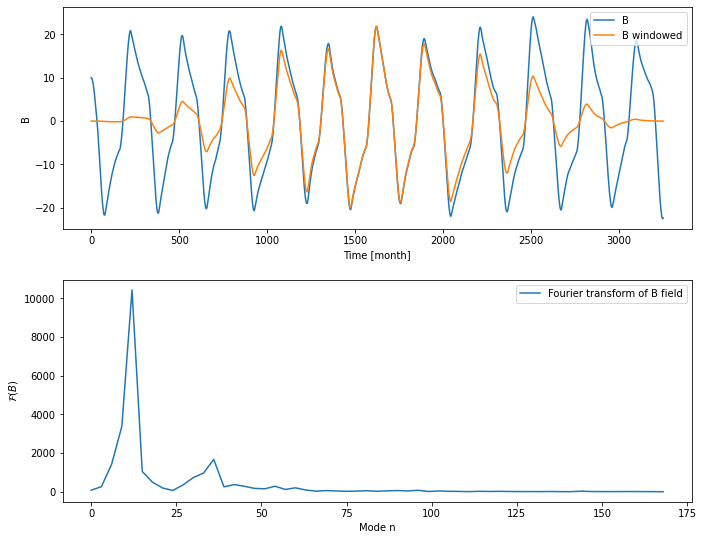

In [17]:
plots(t,B_generated,Bw,n_list)

In [18]:
minima=find_minima(log_prob,p)

Minima [31.11850553 10.17693394 24.18582905 10.11072323 44.24490926] 
 Starting parameters [30, 10, 20, 10.0, 45]


In [19]:
sampler,ndim=sampler_emcee(log_prob,p)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [48:01<00:00,  1.74it/s]


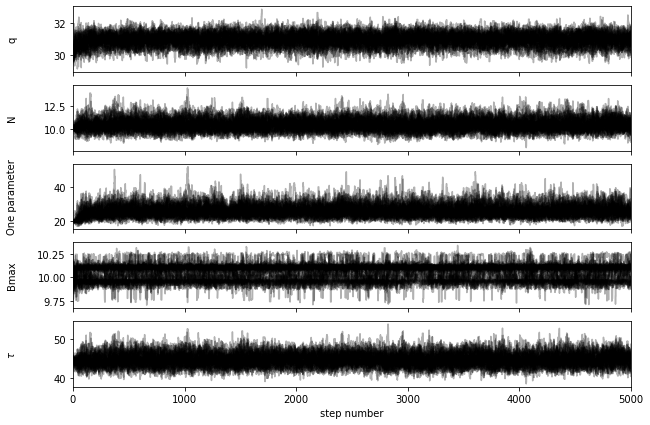

In [20]:
plot_chains(sampler,p,labels,ndim)

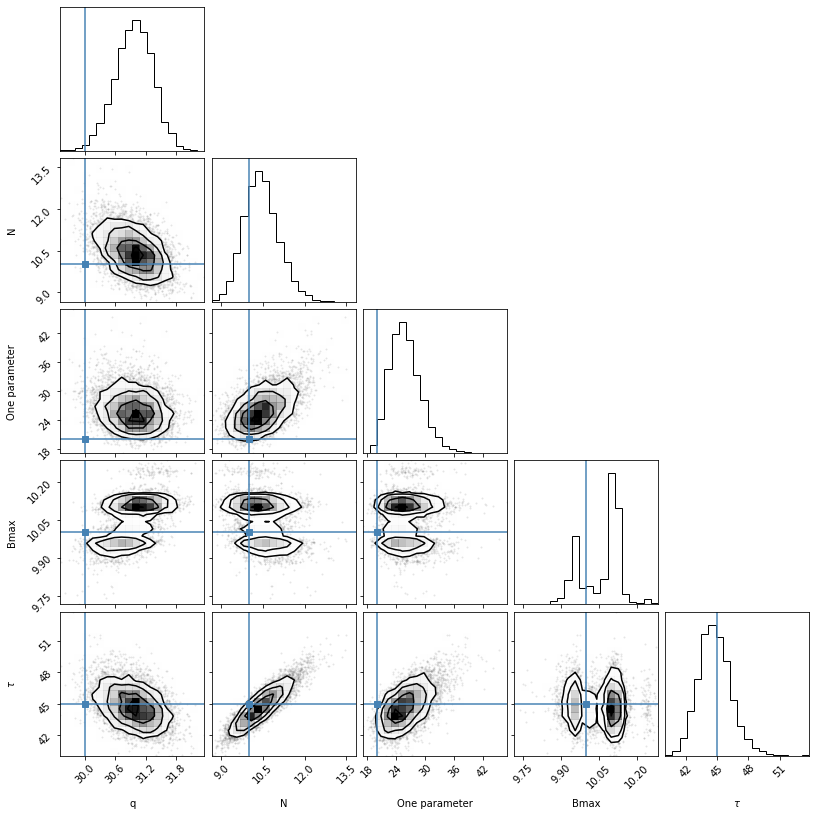

In [21]:
thinning = 40
flat_samples=plot_distributions(sampler,p,burn,thinning,True)

In [22]:
results=show_results(flat_samples,ndim)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

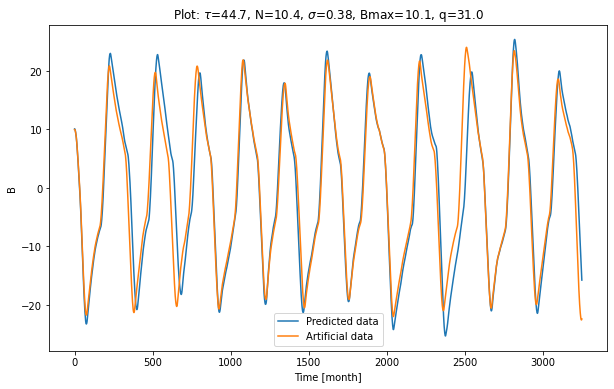

In [23]:
results_ = np.copy(results)
results_[2]=results[2]/results_[3]/np.sqrt(results_[4])
B_generated_predicted=generate_data(results_)
plot_real_and_simulated_data(B_generated_predicted,results_,False)

plt.plot(B_generated,label='Artificial data')
plt.legend(loc='best')
plt.show()

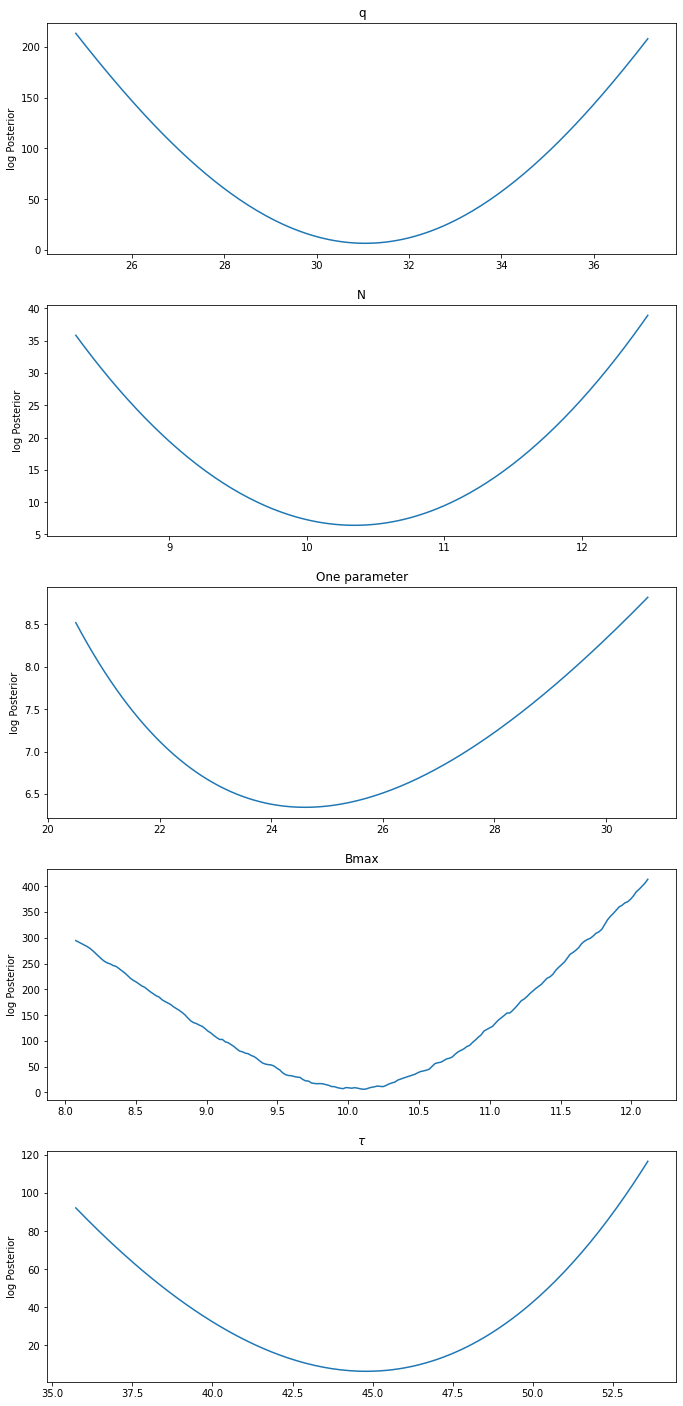

In [24]:
plot_log_prob(results,labels)

### REAL DATA

Now we will infere the parameters for the real data.

In [25]:
q = 105
N = 1.2
one_param= 20
Bmax = 15
tau = 18
sigma=one_param/Bmax/np.sqrt(tau)


if one_parameter:
    sigma=round(one_param/Bmax/np.sqrt(tau),3)
    p = [q, N, one_param, Bmax, tau]
    labels = ["q", "N", "One parameter","Bmax",r"$\tau$"]
else:
    p = [q, N, sigma, Bmax, tau]
    labels = ["q", "N", r"$\sigma$","Bmax",r"$\tau$"]



In [26]:
# Gather all results
log_prob, Bw_hat,Bw,n_list = bayesian_inference(t, B_real, p)

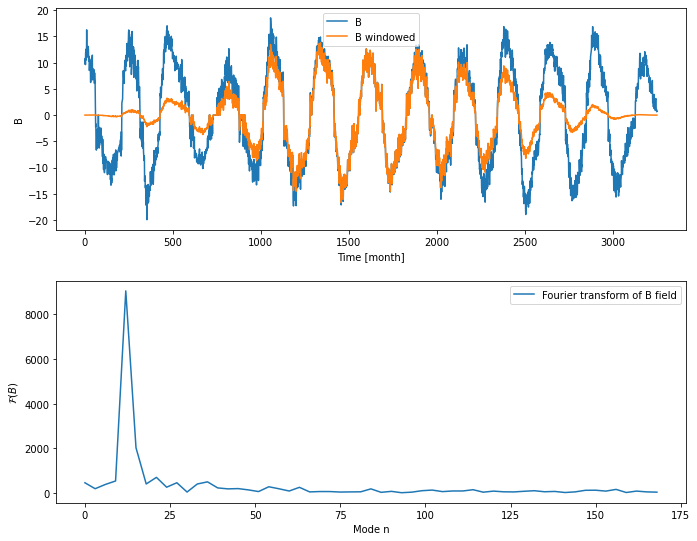

In [27]:
plots(t,B_real,Bw,n_list)

In [28]:
minima=find_minima(log_prob,p)

Minima [106.78831925   1.20451049  23.94089104  14.06107076  11.81592784] 
 Starting parameters [105, 1.2, 20, 15, 18]


In [29]:
sampler,ndim=sampler_emcee(log_prob,p)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [46:26<00:00,  1.79it/s]


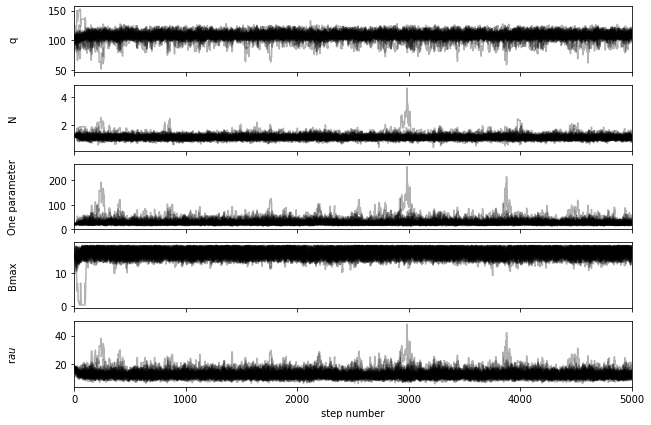

In [30]:
plot_chains(sampler,p,labels,ndim)

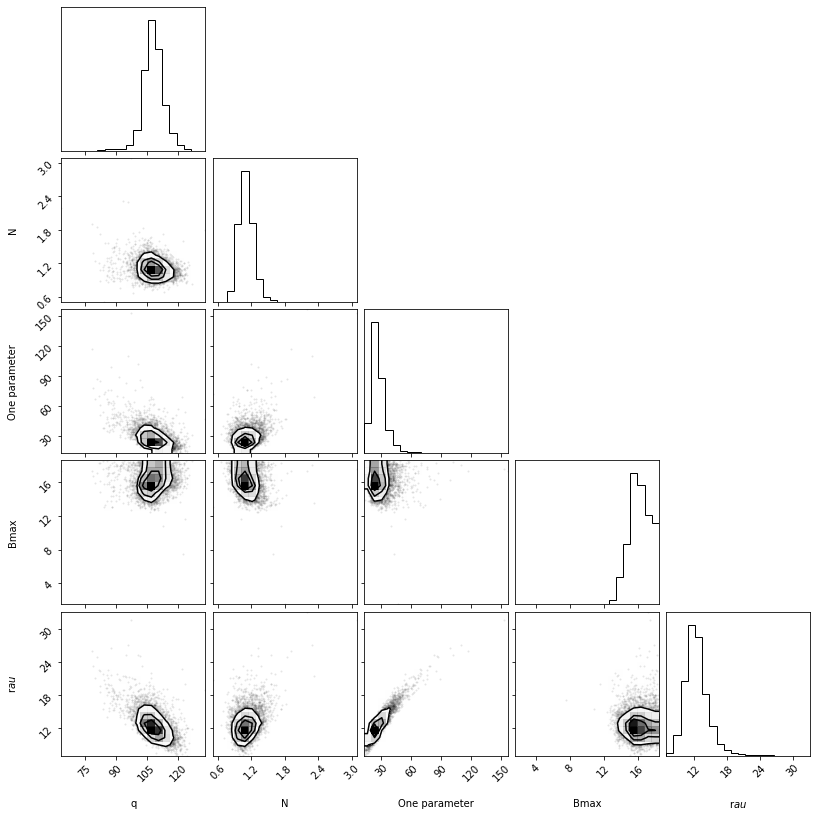

In [31]:
thinning = 40
flat_samples=plot_distributions(sampler,p,burn,thinning,False)

In [32]:
results=show_results(flat_samples,ndim)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

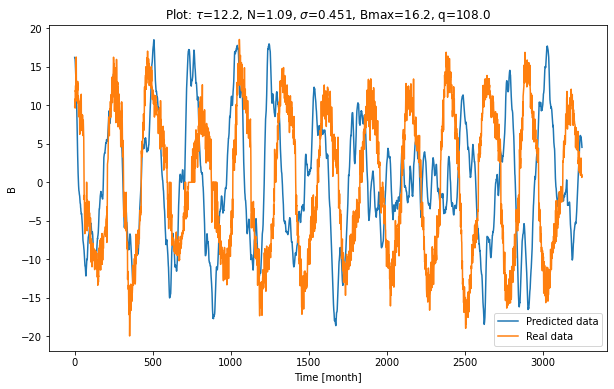

In [33]:
results_ = np.copy(results)
results_[2]=results_[2]/results_[3]/np.sqrt(results_[4])

B_real_predicted=generate_data(results_)
plot_real_and_simulated_data(B_real_predicted,results_,True)


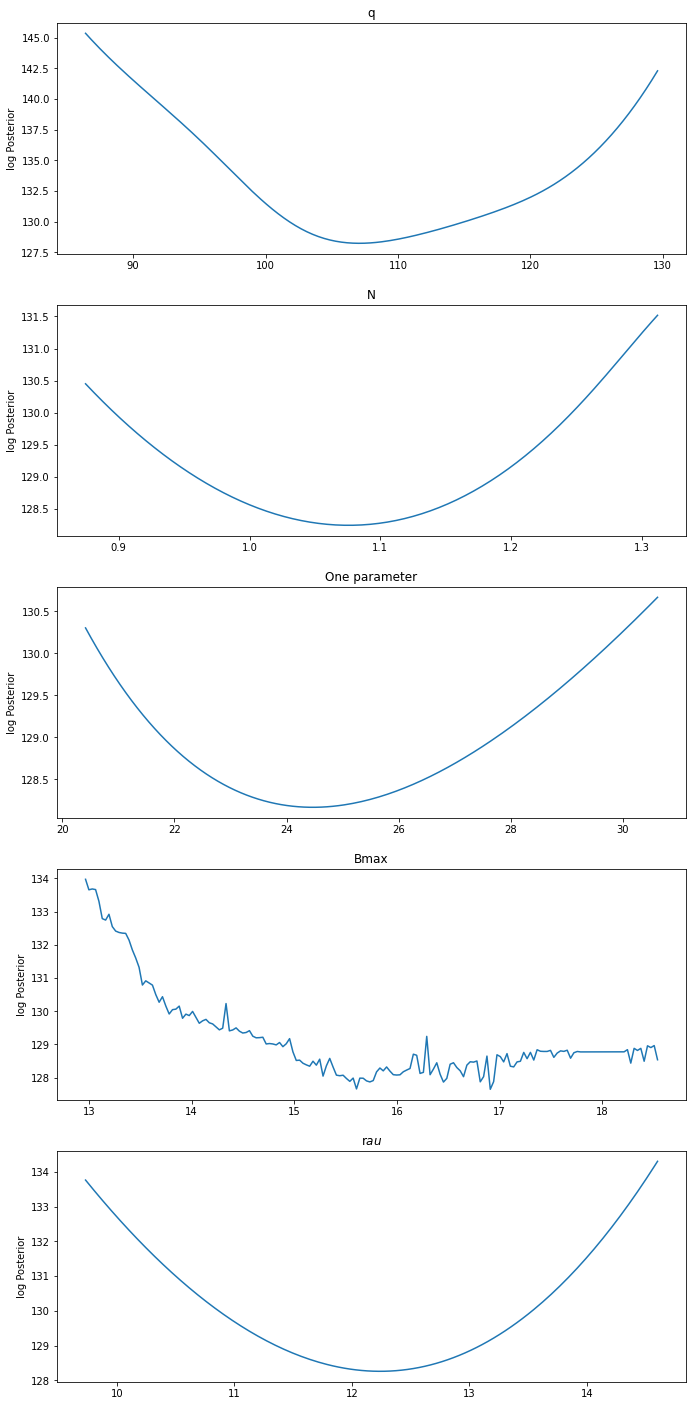

In [34]:
plot_log_prob(results,labels)

Now we want to make a prediction on future data. 

Given the orignal data, we add in continuity the data whose parameters are sampled by the EMCEE sampler.

In [ ]:
results_[2] = results_[2]/(results_[3]*np.sqrt(results_[4]))

In [51]:
prediction=generate_data_predict_no_eps(results_)

t_predicted=np.arange(len(B_real),len(B_real)+1000)

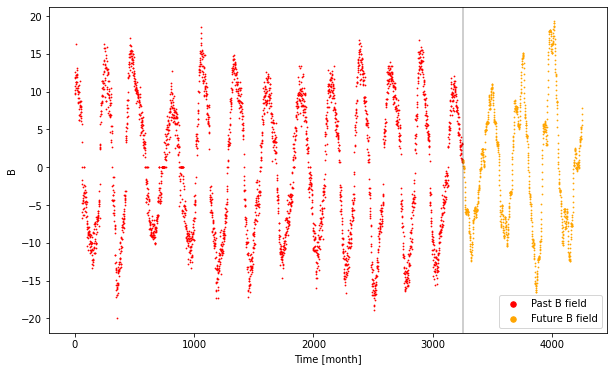

In [52]:
plt.figure(figsize=(10,6))
plt.scatter(t,B_real,c='red',marker='o',s=0.6,label='Past B field')
plt.scatter(t_predicted,prediction[0:1000],c='orange',marker='o',s=0.6,label='Future B field')
plt.axvline(x=len(B_real),linestyle='-',alpha=0.25,c='black')
plt.xlabel('Time [month]')
plt.ylabel('B')
lgnd=plt.legend()
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.show()

## WITH TIDAL FORCING


In a noiseless system that exhibits multiple stable equilibria, it would not be possible to switch between minima, without an external drive that enables to overcome the potential barrier between them. 
In a stochastic system, however, random fluctuations due to noise can occasionally overcome the potential barrier and enable the system to switch between different stable states.

To further amplify the signal to noise ratio in such a system, an external modulation can be introduced, which helps lower—periodically—the potential barrier.
Random noise will then boost the frequency of mode-switching, aided by the external modulation. 

This phenomenon is called _stochastic resonance_. 
In our model equation, the tidal forcing $\epsilon\cos(\omega_d t)$, due to the planets of the Solar System, represents a weak periodic modulation. 
This modulation greatly increases the probability of mode-switching due to the additive white noise. 
In fact, it enables the system to jump frequently between two coexisting stable modes of oscillation: the _weak mode_ is thought to be behind the phenomenon known as Grand Minima, while the _strong mode_ is responsible for the 11-year solar cycle.

Given $\epsilon \neq 0$, the sampling posterior is:

$$
f(\widehat{B}^w|\boldsymbol{\theta}) \propto 
|\det J^{w}| \exp\bigg(-\frac{1}{2\sigma^2 B_{max}^2\tau}\sum_n \bigg\lvert\left(\frac{2 \pi i n\tau}{T} + 1 \right)^2 \widehat{B}^{w}_n + \mathcal{N} e^{-2 \pi i n \frac{q}{T}} \cos^2\left(\pi\frac{q}{T}\right) \mathcal{F}\big\{[1 + \epsilon\cos(\omega_d (t+q))]\widetilde{f}^w\big\}_n\bigg\rvert^2\bigg) \\
$$

In [15]:
one_parameter = True

In [16]:
def bayesian_inference_tidal(t, B, p):
    
    n = np.arange(0, len(t))
    n_list = n[0:n_max:each]
    T=len(t)
    # Define window
    def w(t):
        if WINDOW:
            return np.cos(np.pi * (t / T - 0.5))**2
        else:
            return 1


    # Define box * B
    def f_erf(B,Bmax): 
        if extended_box:
            res = (B/4) * (1+erf(B**2-Bmin**2)) * (1-erf(B**2-Bmax**2))
        else:
            res = 0.5 * (1 - erf(B**2 - Bmax**2)) * B
        return res


    # Find B windowed and Fourier transformed
    Bw = B * w(t) 
    Bw_hat_tot = fft(Bw)

    # Find the derivative of the Fourier transorm of the f tilde
    nm_t = np.multiply.outer(np.subtract.outer(n_list,n_list),t)
    expo = np.exp(-2*np.pi*1j*nm_t/T)


    # Select each 3 modes
    Bw_hat = Bw_hat_tot[0:n_max:each]


    # Variance 
    var_w =np.abs(fft(w(t)**2))


    # Covariance matrix
    cov=(np.diag([var_w[0]]*len(n_list))+np.diag([var_w[1]]*(len(n_list)-1),1)+np.diag([var_w[2]]*(len(n_list)-2),2)+np.diag([var_w[1]]*(len(n_list)-1),-1)+np.diag([var_w[2]]*(len(n_list)-2),-2))
    inv_cov=np.linalg.inv(cov)
    
    if maximum:    
        Bmax_max=max(B)
        q_max=3*q
    
    else:
        Bmax_max=np.inf
        q_max=np.inf


    if one_parameter:
        # Define log_prior
        def log_prior(theta):
            q, N, one_param, Bmax, tau, epsilon, wd = theta
            if (q      > 0     and
                q      < q_max and
                N      > 0    and
                one_param  >0 and
                Bmax   > 0 and 
                Bmax < Bmax_max and
                tau    > 0 and
                epsilon > 0 and epsilon < 1 and
                wd > 0 and wd < 0.1):
                if jeffrey_prior:
                    return -0.5*np.log(one_param)   
                else:
                    return 1
            else:
                return -np.inf


        # Define log_likelihood
        def log_likelihood(theta):
            q, N, one_param, Bmax, tau, epsilon, wd = theta

            koef = (2 * np.pi * 1j * n_list * tau /T + 1)

            f = f_erf(B,Bmax)
            f_hat = fft(f*w(t))
            f_hat = f_hat[0:n_max:each]
            
            f_eps = f_erf(B,Bmax) * np.cos(wd*(t+q))
            f_eps_hat = fft(f_eps * w(t))
            f_eps_hat = f_eps_hat[0:n_max:each]

            if extended_box:
                func = 0.25*(1-erf(B**2 - Bmax**2))*(1+erf(B**2 - Bmin**2)) - (B**2/np.sqrt(np.pi))*(1+erf(B**2 - Bmin**2))*np.exp(-(B**2 - Bmax**2)**2) + (B**2/np.sqrt(np.pi))*(1-erf(B**2 - Bmax**2))*np.exp(-(B**2 - Bmin**2)**2)    
            else:
                func = -(2 * B**2 / np.sqrt(np.pi)) * np.exp(-(B**2 - Bmax**2)**2) - 0.5 * erf((B**2 - Bmax**2)) + 0.5  #derivative of ftilde
            dFf_dBhat = expo @ func / len(t)
            dFf_dBhat_eps = expo @ (func * np.cos(wd*(t+q))) / len(t)

            if covariance:
                if cos:
                    eta_hat = (koef**2 * Bw_hat + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * np.cos(np.pi * q / T)**2 * (f_hat + epsilon * f_eps_hat))/one_param
                    jacobian = (np.diag(koef**2) + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * np.cos(np.pi * q / T)**2 * (dFf_dBhat + epsilon * dFf_dBhat_eps))/one_param
                    det_j = np.abs(det(jacobian))
                else:
                    eta_hat = (koef**2 * Bw_hat + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * (f_hat + epsilon * f_eps_hat))/one_param
                    jacobian = (np.diag(koef**2) + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * (dFf_dBhat + epsilon * dFf_dBhat_eps))/one_param
                    det_j = np.abs(det(jacobian))

                log_likelihood = np.log(det_j)  -   0.5 * np.abs(np.conjugate(eta_hat)@inv_cov@eta_hat)

            else:
                if cos:
                    eta_hat = (koef**2 * Bw_hat + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * np.cos(np.pi * q / T)**2 * (f_hat + epsilon * f_eps_hat))/one_param
                    jacobian = (np.diag(koef**2) + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * np.cos(np.pi * q / T)**2 * (dFf_dBhat + epsilon * dFf_dBhat_eps))/one_param
                    det_j = np.abs(det(jacobian))
                else:
                    eta_hat = (koef**2 * Bw_hat + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * (f_hat + epsilon * f_eps_hat))/one_param
                    jacobian = (np.diag(koef**2) + N * np.exp(-2 * np.pi * 1j * n_list * q / T) * (dFf_dBhat + epsilon * dFf_dBhat_eps))/one_param
                    det_j = np.abs(det(jacobian))

                log_likelihood =  - 0.5 * np.sum(np.abs(eta_hat)**2) / var_w[0] +np.log(det_j)
                #print(log_likelihood)

            return log_likelihood


        # Define log_posterior   
        def log_probability(theta):
            q, N, sigma, Bmax, tau, epsilon, wd = theta
            lp = log_prior(theta)
            if not np.isfinite(lp):
                return -np.inf
            else:
                return lp + log_likelihood(theta)



    else:
        print('ONLY ONE PARAMETER!')
            
    return log_probability, Bw_hat,Bw,n_list

In [17]:
def generate_data_tidal(p):
    q, N, sigma, Bmax, tau, epsilon, wd = p
    
    julia_code = f"""
    include("SDDE_epsilon.jl")
    
    q={q}
    N = {N}
    sigma = {sigma}
    Bmax = {Bmax}
    tau = {tau}
    epsilon = {epsilon}
    wd = {wd}
    p = (q, N, sigma, Bmax, tau, epsilon, wd)

    simulated_data(p)
    """

    Main.eval(julia_code)

    filename = f"SunspotSimulatedData_q{q}_N{N}_sigma{sigma}_Bmax{Bmax}_tau{tau}_epsilon{epsilon}_wd{wd}.csv"
    
    data_simulated = np.loadtxt(filepath + filename, delimiter=',')
    
    return(data_simulated)

In [18]:
def plot_real_and_simulated_data_tidal(data_simulated, p, compare_real):
    q, N, sigma, Bmax, tau, epsilon, wd = p

    plt.figure(figsize=(10,6))
    plt.plot(data_simulated, label="Predicted data")
    if compare_real:
        plt.plot(B_real, label="Real data")
    
    plt.title(fr"Plot: $\tau$={round(tau,1)}, N={round(N,2)}, $\sigma$={round(sigma,3)}, Bmax={round(Bmax,1)}, q={round(q,1)}, epsilon={round(epsilon,3)}, wd={round(wd,4)}")
    plt.xlabel('Time [month]')
    plt.ylabel('B')
    plt.legend()
   # plt.show()

In [19]:
def generate_data_predict(p):
    q, N, sigma, Bmax, tau, epsilon, wd = p
    
    julia_code = f"""
    include("Predict.jl")
    
    q={q}
    N = {N}
    sigma = {sigma}
    Bmax = {Bmax}
    tau = {tau}
    epsilon = {epsilon}
    wd = {wd}
    p = (q, N, sigma, Bmax, tau, epsilon, wd)

    simulated_data(p)
    """

    Main.eval(julia_code)

    filename = f"SunspotSimulatedData_q{q}_N{N}_sigma{sigma}_Bmax{Bmax}_tau{tau}_epsilon{epsilon}_wd{wd}.csv"
    
    data_simulated = np.loadtxt(filepath + filename, delimiter=',')
    
    return(data_simulated)

### ARTIFICIAL DATA

As before, we start with artificial data.

In [20]:
## ONLY VALID FOR ONE PARAMETER
one_parameter=True

In [21]:
q = 30
N = 10
one_param= 20
Bmax = 10.0 
tau = 45
sigma=one_param/Bmax/np.sqrt(tau)
epsilon=0.5
wd=0.002



sigma=round(one_param/Bmax/np.sqrt(tau),3)
p = [q, N, one_param, Bmax, tau,epsilon,wd]
labels = ["q", "N", "One parameter","Bmax",r"\$tau$",r'\$epsilon$',r'\$omega$d']



In [22]:
p_ = [q, N, sigma, Bmax, tau,epsilon,wd]
B_generated=generate_data_tidal(p_)

In [23]:
# Gather all results
log_prob, Bw_hat,Bw,n_list = bayesian_inference_tidal(t, B_generated, p)

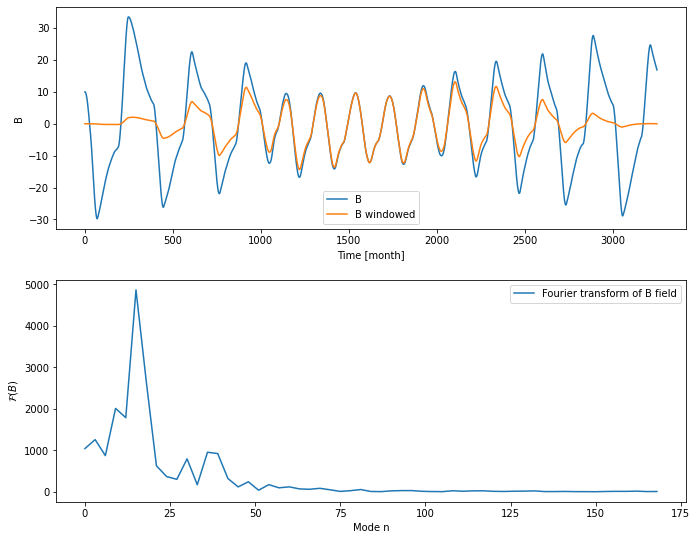

In [24]:
plots(t,B_generated,Bw,n_list)

In [25]:
minima=find_minima(log_prob,p)

C:\Users\prafl\anaconda3\envs\qml\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Minima [3.13448686e+01 8.96282476e+00 1.95414875e+01 1.01118669e+01
 4.11067179e+01 5.35955488e-01 1.88282120e-03] 
 Starting parameters [30, 10, 20, 10.0, 45, 0.5, 0.002]


In [26]:
# use this setup just for showing some results, use 5000 steps and 50 walkers for more stable results

steps_emcee = 1000
walkers = 20
rep_emcee = 1

sampler,ndim=sampler_emcee(log_prob,p)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:44<00:00,  2.15it/s]


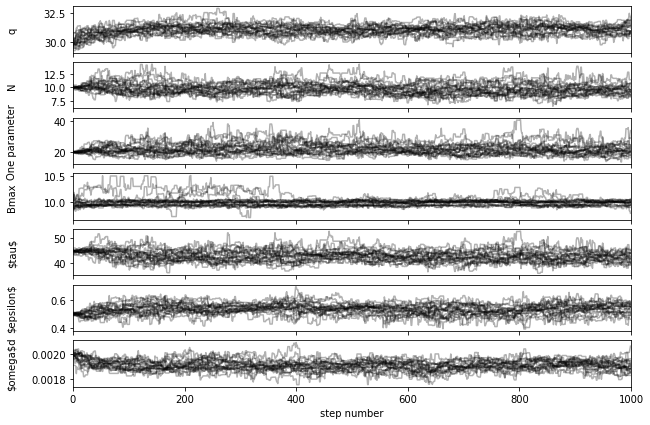

In [27]:
plot_chains(sampler,p,labels,ndim)

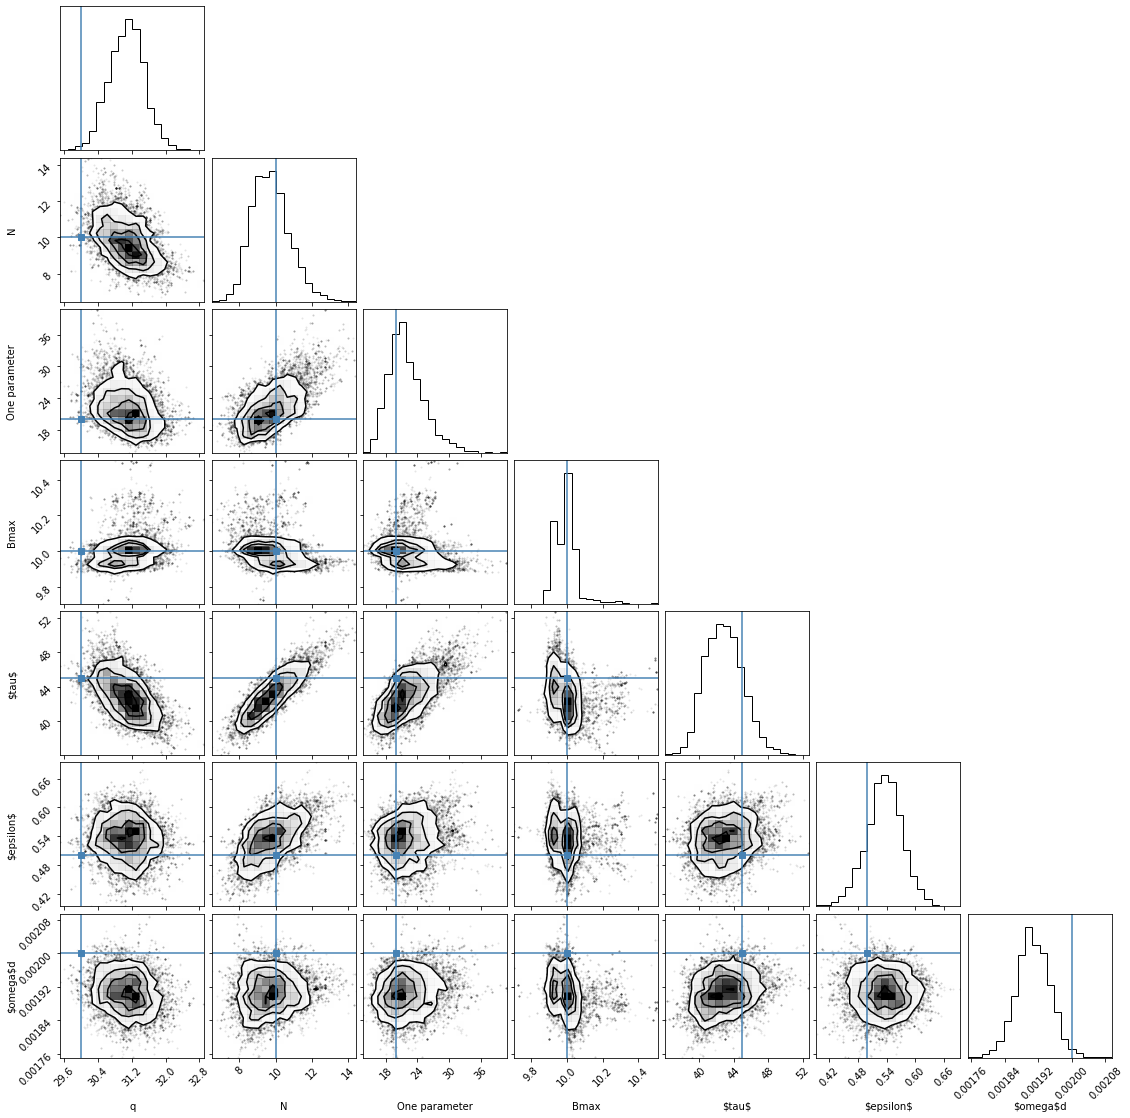

In [28]:
thinning = 1  # use 40 with 5000 steps and 50 walkers
flat_samples=plot_distributions(sampler,p,burn,thinning,True)

In [29]:
results=show_results(flat_samples,ndim)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The mariginal parameter posterior distributions are well defined, except for Bmax which presents 3 main peaks.

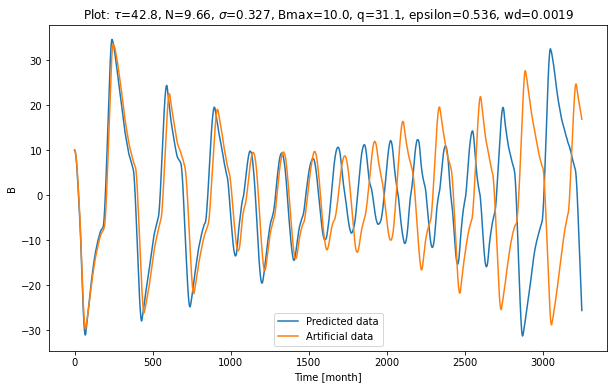

In [30]:
results_ = np.copy(results)
results_[2]=results[2]/results_[3]/np.sqrt(results_[4])
B_generated_predicted=generate_data_tidal(results_)
plot_real_and_simulated_data_tidal(B_generated_predicted,results_,False)

plt.plot(B_generated,label='Artificial data')
plt.legend(loc='best')
plt.show()

The predicted datas do not follow the original ones, actually the trend is quite the same, but the amplitude, delay and noise are not correctly represented.

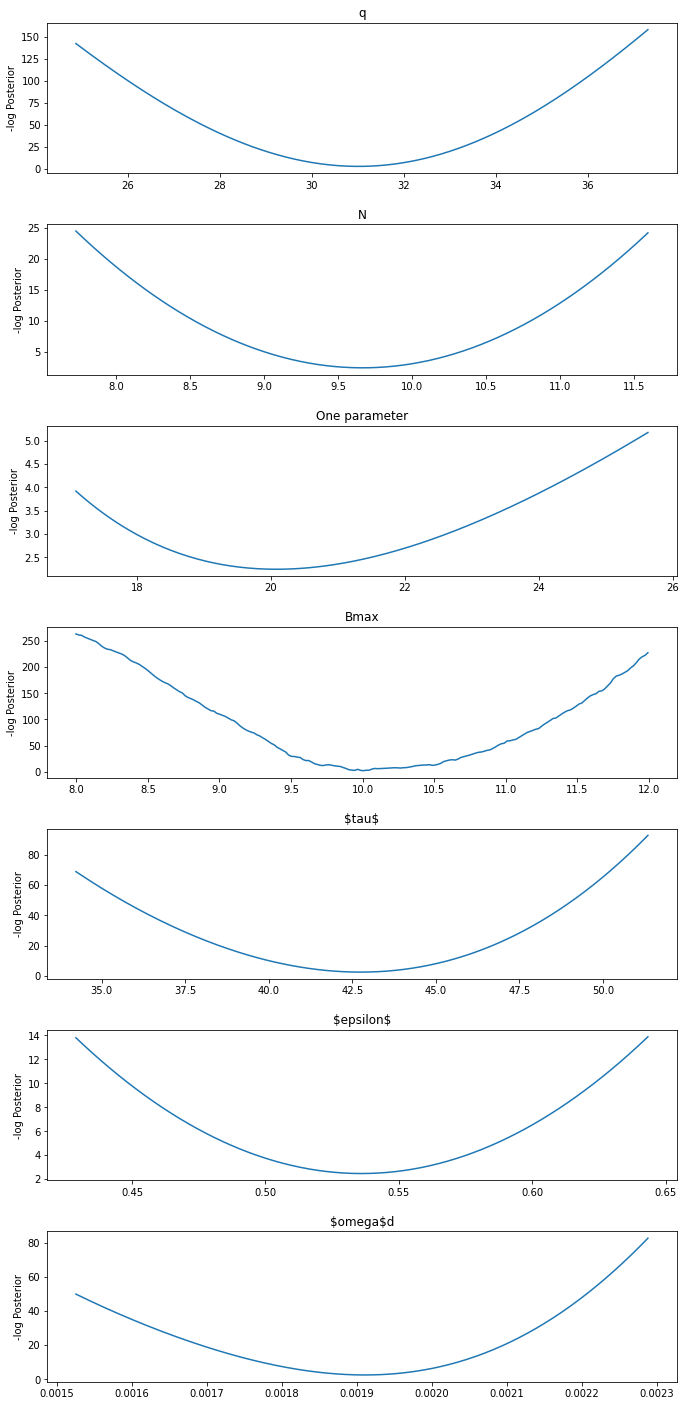

In [31]:
plot_log_prob(results,labels)

### REAL DATA

We finally proceed with the real data.

In [32]:
q = 105
N = 1.14
one_param= 26.7
Bmax = 15.3
tau = 12.59
epsilon = 0.5
wd = 0.002


sigma=round(one_param/Bmax/np.sqrt(tau),3)
p = [q, N, one_param, Bmax, tau,epsilon,wd]
labels = ["q", "N", "One parameter","Bmax","tau",'epsilon','wd']

In [33]:
# Gather all results
log_prob, Bw_hat,Bw,n_list = bayesian_inference_tidal(t, B_real, p)

In [34]:
minima=find_minima(log_prob,p)


# With the next code we can also make multiple minimizing process to find a steady state
# for the parameters and use that final parameters in the EMCEE sampler

#p_minimize = p
#num_minimize_processes = 3
#for i in range(num_minimize_processes):
#    minima=find_minima(log_prob,p_minimize)
#    p_minimize = minima
#    
#p = minima

C:\Users\prafl\anaconda3\envs\qml\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\prafl\anaconda3\envs\qml\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\prafl\anaconda3\envs\qml\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\prafl\anaconda3\envs\qml\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Minima [1.05248223e+02 1.21400745e+00 2.62426599e+01 1.59058932e+01
 1.25864793e+01 1.76273710e-03 3.38812665e-02] 
 Starting parameters [105, 1.14, 26.7, 15.3, 12.59, 0.5, 0.002]


In [35]:
# use this setup just for showing some results, use 5000 steps and 50 walkers for more stable results

steps_emcee = 1000
walkers = 20
rep_emcee = 1

sampler,ndim=sampler_emcee(log_prob,p)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:17<00:00,  3.15it/s]


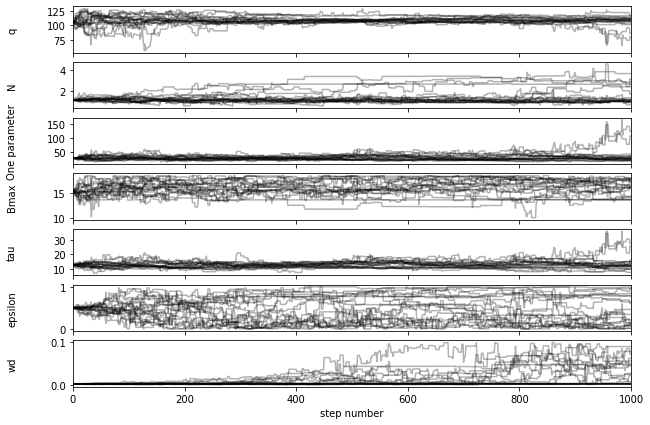

In [36]:
plot_chains(sampler,p,labels,ndim)

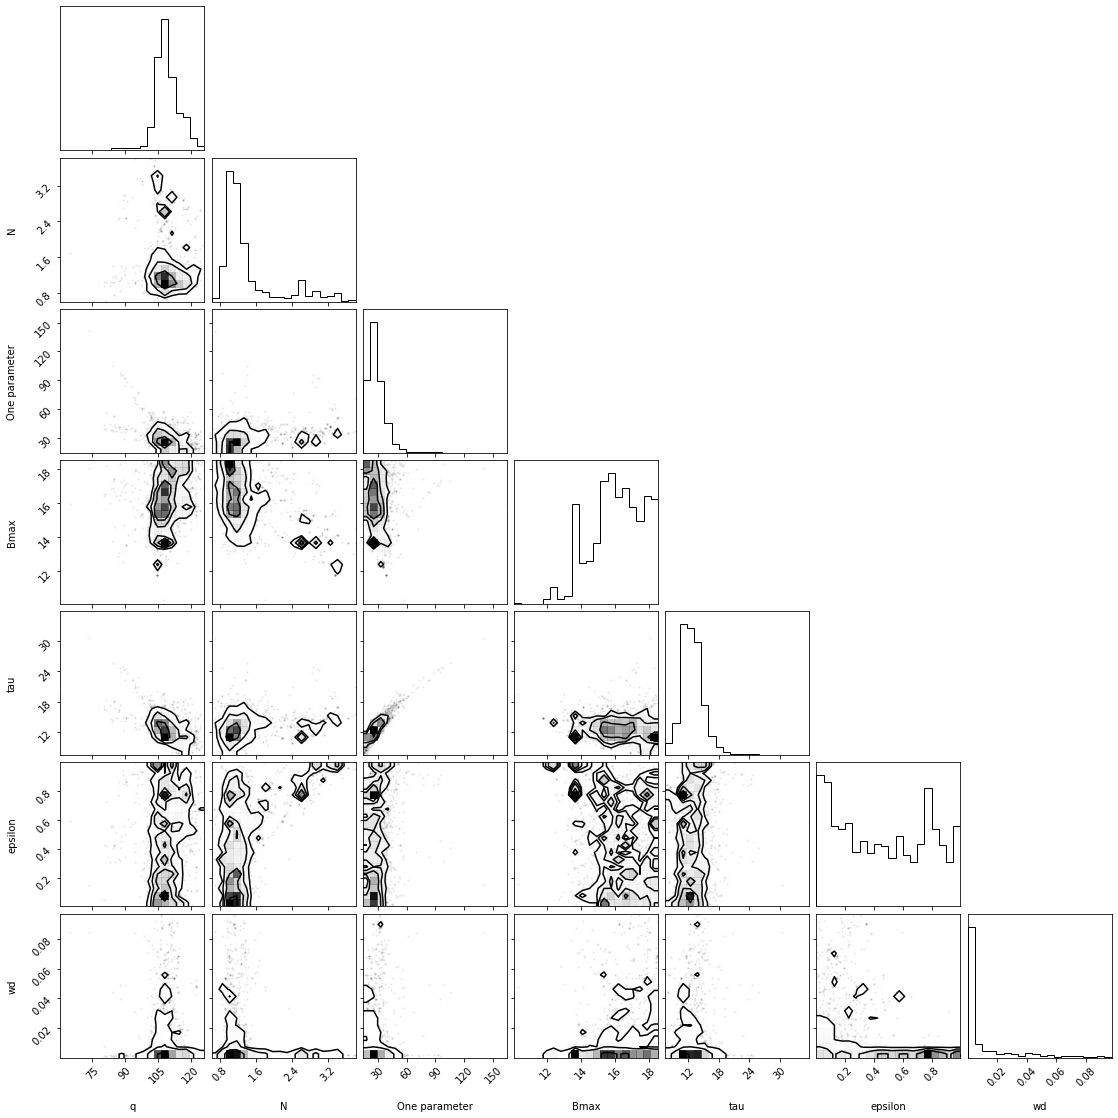

In [43]:
thinning = 10  # use 40 with 5000 steps and 50 walkers
flat_samples=plot_distributions(sampler,p,burn,thinning,False)

The marginal paramater distribution are not well found. The contour plots are not defined. The EMCEE sampler is not able to find a stable values for the model parameters.

In [38]:
results=show_results(flat_samples,ndim)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

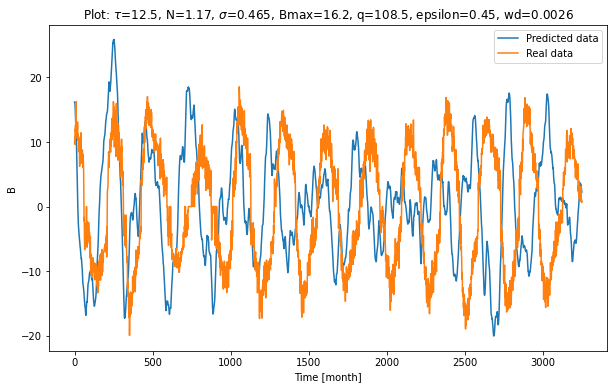

In [39]:
results_ = np.copy(results)
results_[2]=results_[2]/results_[3]/np.sqrt(results_[4])

B_real_predicted=generate_data_tidal(results_)
plot_real_and_simulated_data_tidal(B_real_predicted,results_,True)


Beside the fact that the parameter posterior marginal distributions do not lead us to stable parameter values, the predicted data are quite similar to the real ones, except for a shift in time.

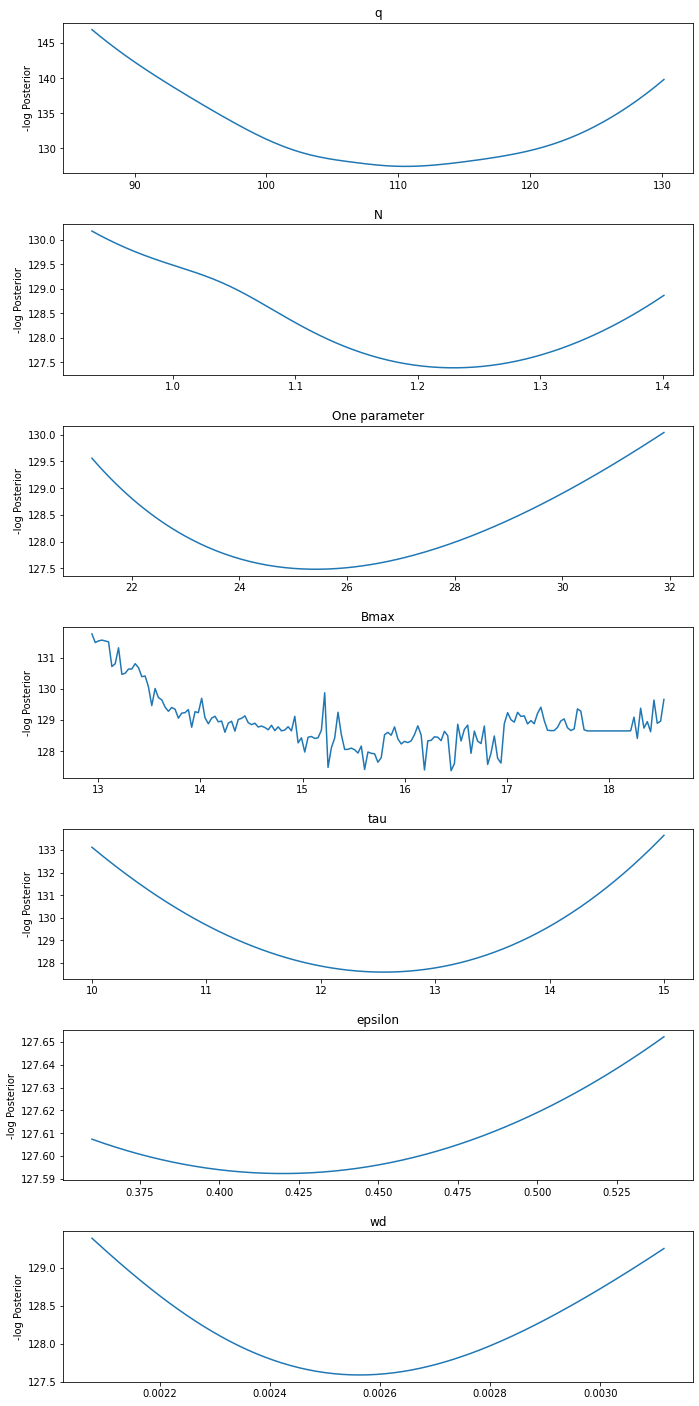

In [40]:
plot_log_prob(results,labels)

Now we want to make a prediction on future data. 

Given the orignal data, we add in continuity the data whose parameters are sampled by the EMCEE sampler.

In [41]:
prediction=generate_data_predict(results_)

t_predicted=np.arange(len(B_real),len(B_real)+1000)

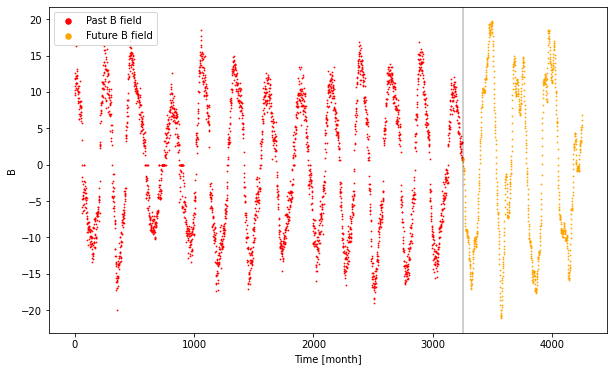

In [42]:
plt.figure(figsize=(10,6))
plt.scatter(t,B_real,c='red',marker='o',s=0.6,label='Past B field')
plt.scatter(t_predicted,prediction[0:1000],c='orange',marker='o',s=0.6,label='Future B field')
plt.axvline(x=len(B_real),linestyle='-',alpha=0.25,c='black')
plt.xlabel('Time [month]')
plt.ylabel('B')
lgnd=plt.legend()
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.show()